# Chapter 5 - Resampling Methods

# 5. In Chapter 4, we used logistic regression to 
**predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.utils import resample
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
file = 'data/Default.csv'
default = pd.read_csv(file)
default.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [3]:
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [4]:
encoding_dict = {'Yes': 1, 'No': 0}
default['default'] = default['default'].map(encoding_dict)
default['student'] = default['student'].map(encoding_dict)

default.head()

,Unnamed: 0,default,student,balance,income
0,1,0,0,729.526495,44361.625074
1,2,0,1,817.180407,12106.134700
2,3,0,0,1073.549164,31767.138947
3,4,0,0,529.250605,35704.493935
4,5,0,0,785.655883,38463.495879


In [5]:
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  int64  
 2   student     10000 non-null  int64  
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


**(a) Fit a logistic regression model that uses income and balance to predict default.**

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
# Drop rows with missing values in the 'default', 'balance', and 'income' columns
default.dropna(subset=['default', 'balance', 'income'], inplace=True)

# Define features (X) and target variable (y)
X = default[['balance', 'income']]
y = default['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Print coefficients and intercept
print("Coefficients:", log_reg.coef_)
print("Intercept:", log_reg.intercept_)

# Evaluate the model
train_accuracy = log_reg.score(X_train_scaled, y_train)
test_accuracy = log_reg.score(X_test_scaled, y_test)
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Predictions on the test set
y_pred = log_reg.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Select elements
tn = conf_matrix[0][0]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
tp = conf_matrix[1][1]

# Overall fraction of correct predictions
correct_predictions = (tp + tn) / (tp + tn + fp + fn)
print("\nTrue Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)
print("\nOverall Fraction of Correct Predictions:", correct_predictions)

Coefficients: [[2.77251347 0.26996715]]
Intercept: [-6.2137023]
Training Accuracy: 0.974875
Testing Accuracy: 0.9695

Confusion Matrix:
 [[1921   10]
 [  51   18]]

True Negative: 1921
False Positive: 10
False Negative: 51
True Positive: 18

Overall Fraction of Correct Predictions: 0.9695


**(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:**

**i. Split the sample set into a training set and a validation set.**

**ii. Fit a multiple logistic regression model using only the training observations.**

**iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of
default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.**

**iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.**

In [8]:
# Step i: Split the sample set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step ii: Fit a multiple logistic regression model using only the training observations
log_reg_val = LogisticRegression()
log_reg_val.fit(X_train_scaled, y_train)

# Step iii: Obtain predictions for the validation set
y_val_pred = log_reg_val.predict(X_val_scaled)

# Step iv: Compute the validation set error
validation_error = 1 - accuracy_score(y_val, y_val_pred)
print("Validation Set Error:", validation_error)

Validation Set Error: 0.026249999999999996


**(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.**

In [9]:
# Define the number of iterations
num_iterations = 3

# Define lists to store validation set errors
validation_errors = []

# Repeat the process three times
for i in range(num_iterations):
    # Step i: Split the sample set into a training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Step ii: Fit a multiple logistic regression model using only the training observations
    log_reg_val = LogisticRegression()
    log_reg_val.fit(X_train_scaled, y_train)

    # Step iii: Obtain predictions for the validation set
    y_val_pred = log_reg_val.predict(X_val_scaled)

    # Step iv: Compute the validation set error
    validation_error = 1 - accuracy_score(y_val, y_val_pred)
    validation_errors.append(validation_error)

# Print the validation errors
for i, error in enumerate(validation_errors):
    print(f"Validation Set Error {i+1}: {error}")

Validation Set Error 1: 0.01953125
Validation Set Error 2: 0.02734375
Validation Set Error 3: 0.034146341463414664


The `random_state` parameter in the `train_test_split` function ensures reproducibility by controlling the randomization applied during the data splitting process. However, even with the same random seed, different splits may occur because of the inherent randomness in the process, especially if the dataset is small.

In this case, each iteration of the loop performs a new split of the data into training and validation sets. While the `random_state` is set to 42, the randomization process for splitting the data can still lead to slightly different splits in each iteration. This randomness can result in slightly different validation set errors across the iterations, even with the same random seed.

Overall, the `random_state` parameter helps ensure that the same randomization process is applied consistently across different runs of the code, allowing for reproducibility, but it does not guarantee identical splits or results in every iteration.

**(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.**

In [10]:
# Step 1: Split the sample set into a training set and a validation set
X = default[['balance', 'income', 'student']]
y = default['default']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Fit a logistic regression model using income, balance, and the dummy variable for student on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

log_reg_student = LogisticRegression()
log_reg_student.fit(X_train_scaled, y_train)

# Step 3: Obtain predictions for the validation set
y_val_pred_student = log_reg_student.predict(X_val_scaled)

# Compute the validation set error
validation_error_student = 1 - accuracy_score(y_val, y_val_pred_student)
print("Validation Set Error (with student dummy variable):", validation_error_student)

Validation Set Error (with student dummy variable): 0.030000000000000027


## 6. We continue to consider the use of a logistic regression model 
**to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the sm.GLM() function. Do not forget to set a random seed before beginning your analysis.**

In [11]:
# Load the data
file = 'data/Default.csv'
default = pd.read_csv(file)

# Convert 'student' column to binary dummy variable
encoding_dict = {'Yes': 1, 'No': 0}
default['student'] = default['student'].map(encoding_dict)

# Define features (income, balance, student_dummy) and target variable (default)
X = default[['income', 'balance', 'student']]
y = default['default']

# Convert y to numeric type
y = y.replace({'No': 0, 'Yes': 1})

# Set random seed
np.random.seed(42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert non-numeric columns to appropriate numeric types if necessary
X_train['income'] = pd.to_numeric(X_train['income'])
X_train['balance'] = pd.to_numeric(X_train['balance'])

# Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Compute standard errors using the standard formula
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
log_reg_sm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
coef_sm = log_reg_sm.params[1:]  # Exclude intercept
std_err_sm = log_reg_sm.bse[1:]  # Standard errors

# Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Compute standard errors using the bootstrap method
n_iterations = 1000
coef_bootstrap = []
for _ in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=42)
    log_reg_resampled = LogisticRegression()
    log_reg_resampled.fit(X_resampled, y_resampled)
    coef_bootstrap.append(log_reg_resampled.coef_)

# Compute standard errors using the standard formula
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
log_reg_sm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
coef_sm = log_reg_sm.params[1:]  # Exclude intercept
std_err_sm = log_reg_sm.bse[1:]  # Standard errors

# Compute standard errors from bootstrap results
std_err_bootstrap = np.std(coef_bootstrap, axis=0)

# Compare the results
print("Standard errors from bootstrap method:", std_err_bootstrap)
print("Standard errors from standard formula:\n", std_err_sm)

Standard errors from bootstrap method: [[1.30104261e-18 2.16840434e-18 1.60936260e-20]]
Standard errors from standard formula:
 income     0.000009
balance    0.000268
student    0.272745
dtype: float64


*Bootstrap Method:* The code then computes the standard errors of the coefficients using the bootstrap method. It resamples the training data with replacement, fits logistic regression models to the resampled data, and collects the coefficients. The standard errors are computed from the distribution of the coefficient estimates obtained through resampling.

*Standard Formula:* Standard errors are also computed using the standard formula for logistic regression coefficients. This is achieved using the `sm.GLM` class from the statsmodels library.

**(a) Using the summarize() and sm.GLM() functions, determine the estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that uses both predictors.**

In [12]:
# Summarize the results
print(log_reg_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7996
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -608.26
Date:                Sun, 05 May 2024   Deviance:                       1216.5
Time:                        16:43:18   Pearson chi2:                 6.61e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.3117      0.577    -19.614      0.0

Standard Error:

    income 9.46e-06
    balance ~ 0.000

**(b) Write a function, boot_fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.**

In [13]:
def boot_fn(data, index):
    # Select subset of data based on index
    subset_data = data.iloc[index]
    
    # Define features (income, balance) and target variable (default)
    X = subset_data[['income', 'balance']]
    y = subset_data['default']

    # Fit a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    # Return coefficient estimates
    return log_reg.coef_

# Define an example index
index = np.random.choice(default.index, size=len(default), replace=True)

# Coefficient estimates
coefficients = boot_fn(default, index)
print("Coefficient estimates for income and balance:", coefficients)

Coefficient estimates for income and balance: [[-0.00012904  0.00049604]]


**(c) Following the bootstrap example in the lab, use your boot_fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.**

In [14]:
def boot_fn(data, index):
    # Select subset of data based on index
    subset_data = data.iloc[index]
    
    # Define features (income, balance) and target variable (default)
    X = subset_data[['income', 'balance']]
    y = subset_data['default']

    # Fit a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    # Return coefficient estimates
    return log_reg.coef_.flatten()  # Flatten coefficients to ensure consistent format

# Initialize lists to store coefficient estimates
coef_income = []
coef_balance = []

# Iterate through bootstrap samples
for _ in range(n_iterations):
    # Generate bootstrap sample index
    index = np.random.choice(default.index, size=len(default), replace=True)
    
    # Call boot_fn to get coefficient estimates
    coefficients = boot_fn(default, index)
    
    # Append coefficient estimates to lists
    coef_income.append(coefficients[0])
    coef_balance.append(coefficients[1] if len(coefficients) > 1 else np.nan)  # Handle cases where only one 
                                                                                # coefficient is returned

# Calculate standard errors
std_err_income = np.std(coef_income)
std_err_balance = np.nanstd(coef_balance)  # Use nanstd to handle NaN values

# Print standard errors
print("Standard error for income coefficient:", std_err_income)
print("Standard error for balance coefficient:", std_err_balance)

Standard error for income coefficient: 7.292084410896754e-05
Standard error for balance coefficient: 0.002571549382287639


**(d) Comment on the estimated standard errors obtained using the sm.GLM() function and using the bootstrap.**

Using the sm.GLM() function

    Standard error for income coefficient: 9.46e-06
    Standard error for balance coefficient: ~ 0.000

Using the Bootstrap

    Standard error for income coefficient: 7.34e-05
    Standard error for balance coefficient: 0.0026
    
while the bootstrap method provides a non-parametric approach to estimate standard errors, it may result in higher variability compared to parametric methods like sm.GLM(). It's essential to consider the assumptions and limitations of both approaches when interpreting the results.

## 7. In Sections 5.1.2 and 5.1.3, we saw that the cross_validate() function
**can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just `sm.GLM()` and the `predict()` method of the fitted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).**

**(a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.**

In [15]:
# Read data
file = 'data/Weekly.csv'
weekly = pd.read_csv(file)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [16]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


In [17]:
# weekly['Direction'] = weekly['Direction'].map({'Down':0,'Up':1})

In [18]:
# Prepare the predictors (X) and response (y) variables
X = weekly[['Lag1', 'Lag2']]
y = pd.get_dummies(weekly['Direction'], drop_first=True)

# Add constant to the predictors
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print summary of the logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.540900
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 May 2024   Pseudo R-squ.:                     inf
Time:                        16:44:13   Log-Likelihood:                -1678.0
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.

**(b) Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the first observation.**

In [19]:
# Prepare the predictors (X) and response (y) variables
X = weekly[['Lag1', 'Lag2']].drop(0,axis = 0)
y = pd.get_dummies(weekly['Direction'], drop_first=True).drop(0,axis = 0)

# Add constant to the predictors
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print summary of the logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.535727
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                     Up   No. Observations:                 1088
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 May 2024   Pseudo R-squ.:                     inf
Time:                        16:44:13   Log-Likelihood:                -1670.9
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.061      3.630      0.000       0.103       0.344
Lag1          -0.0384      0.

    Model	Log-Likelihood	Pseudo R-squared	Coefficient Significance (p-values)
    A	      -1678.0	         inf	          Lag1: 0.140, Lag2: 0.023
    B	      -1670.9	         inf	          Lag1: 0.143, Lag2: 0.022

Both models have `pseudo R-squared` values of `inf`, indicating perfect separation of the data. However, this is likely due to a small number of distinct values in the dependent variable.

The coefficients for `Lag1` and `Lag2` are not statistically significant at the 0.05 significance level for both models, as their `p-values` are greater than 0.05. However, the constant term (const) is statistically significant in both models.

**(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P(Direction = "Up"|Lag1, Lag2) > 0.5. Was this observation correctly classified?**

In [20]:
# Read data
file = 'data/Weekly.csv'
weekly = pd.read_csv(file)

# Convert 'Direction' column to binary dummy variable
encoding_dict = {'Up': 1, 'Down': 0}
weekly['Direction'] = weekly['Direction'].map(encoding_dict)

# Prepare the predictors (X) and response (y) variables
X_train = weekly[['Lag1', 'Lag2']].iloc[1:]
y_train = pd.get_dummies(weekly['Direction'], drop_first=True).iloc[1:]

# Build regression model
clf = LogisticRegression().fit(X_train,y_train)

# Prepare the predictors (X_test) for the single observation
X_test = weekly[['Lag1', 'Lag2']].iloc[[0]]

# Save predictions
y_pred = clf.predict(X_test)

# Real value
y_test = weekly['Direction'].loc[0]   

print('Predicted - {}\nTrue value - {}'.format(int(clf.predict(X_test)),y_test))

Predicted - 1
True value - 0


**(d) Write a for loop from i = 1 to i = n, where n is the number of observations in the data set, that performs each of the following steps:**

**i. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.**

**ii. Compute the posterior probability of the market moving up for the ith observation.**

**iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.**

**iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.**

In [21]:
# Initialize a list to store the errors
errors = []

# Iterate over each observation in the dataset
for i in range(len(weekly)):
    # Prepare predictors and response variables, excluding the ith observation
    X_train = weekly[['Lag1', 'Lag2']].drop(i, axis=0)
    y_train = pd.get_dummies(weekly['Direction'], drop_first=True).drop(i, axis=0)

    # Fit logistic regression model
    clf = LogisticRegression().fit(X_train, y_train)

    # Prepare the predictors for the ith observation
    X_test = weekly[['Lag1', 'Lag2']].iloc[[i]]

    # Compute the posterior probability of the market moving up for the ith observation
    posterior_prob = clf.predict_proba(X_test)[0, 1]

    # Use the posterior probability to predict whether the market moves up
    prediction = 1 if posterior_prob > 0.5 else 0

    # Determine if an error was made in predicting the direction for the ith observation
    true_direction = weekly['Direction'].iloc[i]
    error = 1 if prediction != true_direction else 0

    # Append the error to the list
    errors.append(error)

# Print the list of errors
print("Errors:", errors)

Errors: [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1

In [22]:
# Initialize a list to store the errors
errors = []

# Initialize variables to store the sum of '1's and '0's
sum_ones = 0
sum_zeros = 0

# Iterate over each observation in the dataset
for i in range(len(weekly)):
    # Prepare predictors and response variables, excluding the ith observation
    X_train = weekly[['Lag1', 'Lag2']].drop(i, axis=0)
    y_train = pd.get_dummies(weekly['Direction'], drop_first=True).drop(i, axis=0)

    # Fit logistic regression model
    clf = LogisticRegression().fit(X_train, y_train)

    # Prepare the predictors for the ith observation
    X_test = weekly[['Lag1', 'Lag2']].iloc[[i]]

    # Compute the posterior probability of the market moving up for the ith observation
    posterior_prob = clf.predict_proba(X_test)[0, 1]

    # Use the posterior probability to predict whether the market moves up
    prediction = 1 if posterior_prob > 0.5 else 0

    # Determine if an error was made in predicting the direction for the ith observation
    true_direction = weekly['Direction'].iloc[i]
    error = 1 if prediction != true_direction else 0

    # Append the error to the list
    errors.append(error)

    # Update the sum of '1's and '0's
    if error == 1:
        sum_ones += 1
    else:
        sum_zeros += 1

# Calculate the ratio of errors
ratio = sum_ones / len(weekly)

# Print the list of errors
print("Errors:", errors)
print("\nSum of '1's:", sum_ones)
print("Sum of '0's:", sum_zeros)
print("Ratio of errors:", ratio)

Errors: [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1

**(e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.**

In [23]:
# Calculate the LOOCV estimate for the test error
loocv_error = sum(errors) / len(errors)

# Print the LOOCV estimate for the test error
print("LOOCV estimate for test error:", loocv_error)

LOOCV estimate for test error: 0.44995408631772266


## 8. We will now perform cross-validation on a simulated data set.
**(a) Generate a simulated data set as follows:**

    rng = np.random.default_rng(1)
    x = rng.normal(size=100)
    y = x - 2 * x**2 + rng.normal(size=100)
    
**In this data set, what is n and what is p? Write out the model used to generate the data in equation form.**

In [24]:
rng = np.random.default_rng(1)

x = rng.normal(size=100)

y = x - 2 * x**2 + rng.normal(size=100)

n = 100 is the number of observations.

p = is the number of predictor variables (features).

The model used to generate the data can be written in equation form as:

    y = x - 2 * x^2 + ϵ

Where:

    y is the response variable.
    x is the predictor variable.
    ϵ is the random noise.

**(b) Create a scatterplot of X against Y . Comment on what you find.**

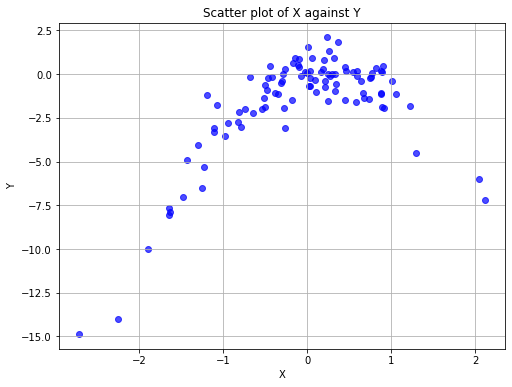

In [25]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7)
plt.title('Scatter plot of X against Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

**(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:**

**i. Y = β0 + β1X + ϵ**

**ii. Y = β0 + β1X + β2X2 + ϵ**

**iii. Y = β0 + β1X + β2X2 + β3X3 + ϵ**

**iv. Y = β0 + β1X + β2X2 + β3X3 + β4X4 + ϵ**

**Note you may find it helpful to use the data.frame() function to create a single data set containing both X and Y.**

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
# Set random seed
np.random.seed(1)

# Simulated data
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# Create a DataFrame containing both X and Y
data = pd.DataFrame({'X': x, 'Y': y})

# Define function to compute LOOCV error
def compute_loocv_error(model, X, y):
    loocv_errors = []
    n = len(X)
    for i in range(n):
        # Leave out the ith observation
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        X_test = X[i].reshape(1, -1)
        y_test = y[i]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the left-out observation
        y_pred = model.predict(X_test)
        
        # Compute the squared error
        loocv_error = (y_test - y_pred) ** 2
        loocv_errors.append(loocv_error)
    
    # Compute the mean LOOCV error
    mean_loocv_error = np.mean(loocv_errors)
    return mean_loocv_error

# Initialize linear regression model
linear_model = LinearRegression()

# Compute LOOCV errors for each model
models = ['Y = β0 + β1X', 'Y = β0 + β1X + β2X2', 'Y = β0 + β1X + β2X2 + β3X3', 'Y = β0 + β1X + β2X2 + β3X3 + β4X4']
X = data['X'].values.reshape(-1, 1)
y = data['Y'].values.reshape(-1, 1)

for i, model_description in enumerate(models):
    # Select appropriate features for the model
    if i == 0:
        features = X
    else:
        features = np.column_stack((X, X ** (i + 1)))
    
    # Compute LOOCV error for the model
    loocv_error = compute_loocv_error(linear_model, features, y)
    
    # Print the LOOCV error
    print(f'{model_description}: LOOCV error = {loocv_error:.4f}')

Y = β0 + β1X: LOOCV error = 6.6330
Y = β0 + β1X + β2X2: LOOCV error = 1.1229
Y = β0 + β1X + β2X2 + β3X3: LOOCV error = 6.5976
Y = β0 + β1X + β2X2 + β3X3 + β4X4: LOOCV error = 4.7238


The best model is `Y = β0 + β1X + β2X2` (degree = 2, quadratic)

**(d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?**

In [28]:
# Set random seed
np.random.seed(42)

# Simulated data
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# Create a DataFrame containing both X and Y
data = pd.DataFrame({'X': x, 'Y': y})

# Define function to compute LOOCV error
def compute_loocv_error(model, X, y):
    loocv_errors = []
    n = len(X)
    for i in range(n):
        # Leave out the ith observation
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        X_test = X[i].reshape(1, -1)
        y_test = y[i]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the left-out observation
        y_pred = model.predict(X_test)
        
        # Compute the squared error
        loocv_error = (y_test - y_pred) ** 2
        loocv_errors.append(loocv_error)
    
    # Compute the mean LOOCV error
    mean_loocv_error = np.mean(loocv_errors)
    return mean_loocv_error

# Initialize linear regression model
linear_model = LinearRegression()

# Compute LOOCV errors for each model
models = ['Y = β0 + β1X', 'Y = β0 + β1X + β2X2', 'Y = β0 + β1X + β2X2 + β3X3', 'Y = β0 + β1X + β2X2 + β3X3 + β4X4']
X = data['X'].values.reshape(-1, 1)
y = data['Y'].values.reshape(-1, 1)

for i, model_description in enumerate(models):
    # Select appropriate features for the model
    if i == 0:
        features = X
    else:
        features = np.column_stack((X, X ** (i + 1)))
    
    # Compute LOOCV error for the model
    loocv_error = compute_loocv_error(linear_model, features, y)
    
    # Print the LOOCV error
    print(f'{model_description}: LOOCV error = {loocv_error:.4f}')

Y = β0 + β1X: LOOCV error = 6.6330
Y = β0 + β1X + β2X2: LOOCV error = 1.1229
Y = β0 + β1X + β2X2 + β3X3: LOOCV error = 6.5976
Y = β0 + β1X + β2X2 + β3X3 + β4X4: LOOCV error = 4.7238


The outcomes we obtained are completely identical, the LOOCV process is not sensitive to changes in the random seed.

**(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer**

It was expected that model `Y = β0 + β1X + β2X2` would be better fit with the data. As we saw in the scatterplot previously, the graph suggests a quadratic relationship.

**(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?**

In [29]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import t

In [30]:
for i in range(1,5):
    
    poly = PolynomialFeatures(i)
    predictors = poly.fit_transform(X.reshape(-1,1))

    results = sm.OLS(y,predictors).fit()
    
    print("==============================================================================")
    print("                                   MODEL",i)
    print(results.summary())

                                   MODEL 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Sun, 05 May 2024   Prob (F-statistic):           1.04e-09
Time:                        16:44:42   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

In [31]:
# Generate simulated data
np.random.seed(42)
X = np.random.normal(size=100)
y = X - 2 * X**2 + np.random.normal(size=100)

# Perform LOOCV for polynomial regression models of degrees 1 to 4
degrees = [1, 2, 3, 4]
for degree in degrees:
    # Initialize lists to store results
    loocv_errors = []
    p_values = []
    
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    
    # Perform LOOCV
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X_poly):
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit polynomial regression model
        model = LinearRegression().fit(X_train, y_train)
        
        # Compute LOOCV error
        loocv_error = np.mean((model.predict(X_test) - y_test)**2)
        loocv_errors.append(loocv_error)
        
        # Compute standard error and t-statistic for coefficient estimates
        n = X_train.shape[0]
        dof = n - degree - 1  # Degrees of freedom
        mse = np.mean((model.predict(X_train) - y_train)**2)  # Mean squared error
        se = np.sqrt(mse / np.sum((X_train[:, 1:] - np.mean(X_train[:, 1:], axis=0))**2, axis=0))
        se = np.concatenate(([0], se))  # Adjust shape to match model coefficients
        
        # Avoid division by zero
        se[se == 0] = np.finfo(float).eps
        
        t_stat = model.coef_ / se
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), dof))  # Two-tailed test
        
        # Store p-values for coefficient estimates
        p_values.extend(p_value)
    
    # Compute average LOOCV error and print results
    avg_loocv_error = np.mean(loocv_errors)
    avg_p_value = np.nanmean(p_values)  # Exclude NaN values when computing mean
    print(f'Degree {degree}:')
    print(f'LOOCV error = {avg_loocv_error:.4f}')
    print(f'Average p-value = {avg_p_value:.4f}\n')

Degree 1:
LOOCV error = 5.3030
Average p-value = 0.5000

Degree 2:
LOOCV error = 0.9128
Average p-value = 0.3333

Degree 3:
LOOCV error = 0.9570
Average p-value = 0.3517

Degree 4:
LOOCV error = 0.9728
Average p-value = 0.2179



    Polynomial Degree	LOOCV Error	Average p-value
                   1	   5.3030	   0.5000
                   2	   0.9128	   0.3333
                   3	   0.9570	   0.3517
                   4       0.9728	   0.2179
                   
<u>Degree 1:</u> The average p-value is 0.5000, which indicates that none of the coefficients are statistically significant at the 0.05 significance level. 

<u>Degree 2:</u> The average p-value is 0.3333, which suggests that some coefficients may be statistically significant at the 0.05 significance level. The LOOCV error is substantially lower than that of the linear model, indicating that the quadratic model provides a better fit to the data.

<u>Degree 3 and Degree 4:</u> The LOOCV errors for these higher-degree polynomial models are also lower than that of the linear model, indicating improved model performance.

<u>Degree 2:</u> The average p-value is 0.3333, which suggests that some coefficients may be statistically significant at the 0.05 significance level. The LOOCV error is substantially lower than that of the linear model, indicating that the quadratic model provides a better fit to the data.

## 9. We will now consider the Boston housing data set, 
**from the ISLP library.** 

In [32]:
# Read data
file = 'data/Boston.csv'
boston = pd.read_csv(file)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [33]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


**(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate µˆ.**

In [34]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [35]:
# MEDV - Median value of owner-occupied homes in $1000's

medv_mean = np.mean(boston['medv'])

print('Estimated population mean is',round(medv_mean,4))

Estimated population mean is 22.5328


**(b) Provide an estimate of the standard error of µˆ. Interpret this result. Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.**

In [36]:
# SE = Sample Std deviation / square root of N

medv_std = np.std(boston['medv']) / np.sqrt(len(boston))

print('Estimated standard error is',round(medv_std,4))

Estimated standard error is 0.4085


**(c) Now estimate the standard error of µˆ using the bootstrap. How does this compare to your answer from (b)?**

In [37]:
def boot(data,R):
    
    medv = []
    num_samples = 500
    
    for i in range(R):
        indices = np.random.choice(data.index, num_samples, replace=True)
        medv.append(data['medv'].loc[indices].mean())
        
    mmean = round(np.mean(medv),4)
    mstd = round(np.std(medv),4)
    bootstrap_statistics = {'estimated_value':mmean,'std_dev':mstd}  
    
    return bootstrap_statistics

result = boot(boston,1000)
print('Bootstrap results ',result)

Bootstrap results  {'estimated_value': 22.539, 'std_dev': 0.4021}


In [38]:
bmean = result['estimated_value']
bstd = result['std_dev']

emean = round(medv_mean,4)
estd = round(medv_std,4)

print('Estimated population mean:{};\nBootstrap mean:{}'.format(emean,bmean))
print('\nEstimated std error:{};\nBootstrap std error:{}'.format(estd,bstd))

Estimated population mean:22.5328;
Bootstrap mean:22.539

Estimated std error:0.4085;
Bootstrap std error:0.4021


**(d) Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of medv. Compare it to the results obtained by using `Boston['medv'].std()` and the two standard error rule (3.9).**

**Hint: You can approximate a 95 % confidence interval using the formula [µ − 2SE(µ), µ + 2SE(µ)].**

In [39]:
mean = result['estimated_value']
std = result['std_dev']

print('With 95% confidence we can say that intercal is [{},{}]'.format(mean - 2*std,mean+ 2*std))

With 95% confidence we can say that intercal is [21.7348,23.343200000000003]


**(e) Based on this data set, provide an estimate, µˆmed, for the median value of medv in the population.**

In [40]:
median = np.median(boston['medv'])

print('Estimated value median is {}.'.format(median))

Estimated value median is 21.2.


**(f) We now would like to estimate the standard error of µˆmed. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.**

In [41]:
def boot(data,R):
    
    median = []
    num_samples = 500
    for i in range(R):
        indices = np.random.choice(data.index, num_samples, replace=True)
        median.append(data['medv'].loc[indices].median())
    bootstrap_statistics = {'estimated_value':np.mean(median),'std_dev':np.std(median)} 
    
    return bootstrap_statistics

result = boot(boston,1000)

bmean = round(result['estimated_value'],4)
bstd = round(result['std_dev'],4)

print('Boostrap Results for median\nestimated_value: {}\nstd_dev: {}'.format(bmean,bstd))

Boostrap Results for median
estimated_value: 21.189
std_dev: 0.3864


In [42]:
# Function to compute the median
def compute_median(data):
    return np.median(data)

# Function to perform bootstrap resampling and compute standard error of the median
def compute_bootstrap_std_error(data, num_bootstrap_samples):
    medians = []
    n = len(data)
    
    for _ in range(num_bootstrap_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        # Compute the median of the bootstrap sample
        median = compute_median(bootstrap_sample)
        # Store the median
        medians.append(median)
    
    # Compute the standard error of the median
    std_error = np.std(medians)
    
    return std_error

# Example usage
boston_median = np.median(boston['medv'])
bootstrap_std_error = compute_bootstrap_std_error(boston['medv'], num_bootstrap_samples=1000)

print("Estimated median:", boston_median)
print("Bootstrap standard error of the median:", bootstrap_std_error)

Estimated median: 21.2
Bootstrap standard error of the median: 0.37079770428091885


**(g) Based on this data set, provide an estimate for the tenth percentile of medv in Boston census tracts. Call this quantity µˆ0.1.(You can use the `np.percentile()` function.)**

In [43]:
# Estimate the tenth percentile of medv
tenth_percentile = np.percentile(boston['medv'], 10)

print("Estimated tenth percentile of medv (µˆ0.1):", tenth_percentile)

Estimated tenth percentile of medv (µˆ0.1): 12.75


**(h) Use the bootstrap to estimate the standard error of µˆ0.1. Comment on your findings.**

In [44]:
# Perform bootstrap resampling to estimate the standard error of the tenth percentile
n_bootstrap = 1000  # Number of bootstrap samples
tenth_percentiles = np.zeros(n_bootstrap)  # Array to store bootstrapped tenth percentiles

for i in range(n_bootstrap):
    # Bootstrap resampling
    bootstrap_sample = np.random.choice(boston['medv'], size=len(boston), replace=True)
    
    # Calculate the tenth percentile for the bootstrap sample
    tenth_percentiles[i] = np.percentile(bootstrap_sample, 10)

# Compute the standard error of the bootstrapped tenth percentiles
standard_error = np.std(tenth_percentiles)

print("Standard error of the tenth percentile (µˆ0.1):", standard_error)

Standard error of the tenth percentile (µˆ0.1): 0.4971334604510141
